In [ ]:
import chess
import chess.pgn
import numpy as np
import pandas as pd
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# Const variables for parsing the raw data 

BOARD_SIZE = (7, 8, 8)
PIECE_INDEX = {'P' : 0, 'R' : 1, 'N' : 2, 'B' : 3, 'Q' : 4, 'K' : 5}
PATTERN = ['r', 'n', 'b', 'q', 'k', 'p', 'P','R', 'N', 'B', 'Q', 'K']

In [ ]:
def board_to_list(board):
  #a list to store the rows
  pieces = []
  #split into rows and remove tail info
  temp = board.board_fen().split("/")
  #for each row, split the individual characters out
  for r in temp:
    #create an empty list to add to
    l = []
    #check if each character is a digit
    for c in r:
      #if it is, append empty char to the list the number of times equal to the digit
      if c.isdigit():
        for i in range(int(c)):
          l.append(' ')
      #otherwise append the character
      else:
        l.append(c)
    #append the list of characters to our list of pieces
    pieces.append(l)
  return pieces


In [ ]:
# Function returns 1 when White player win, 0.5 for draw, 0 for lose
def get_result(game):
  if game.headers['Result'] == '1-0':
    return 1
  elif game.headers['Result'] =='1/2-1/2':
    return 0.5
  else:
    return 0

In [ ]:
# function to change the board (FEN) object to input 

def board_to_input(board, prev_board=None):
  input = np.zeros(BOARD_SIZE) # create 7 channels with 8x8 numpy array
  board_list = board_to_list(board) # change the board to list

  for col in range(len(board_list)):
    for row in range(len(board_list[0])):
      if board_list[col][row] == ' ': continue # if the board is space(blank position), leave it as zero
      if board_list[col][row].isupper():
        input[ PIECE_INDEX[board_list[col][row]], col, row ] = 1 # white player pieces 
      else:
        input[ PIECE_INDEX[board_list[col][row].upper()], col, row ] = -1 # black player pieces

  if prev_board is not None: 
    prev_board = np.flip(prev_board,1)*-1 # need to flip and multiply by -1 (change the board to a perspective from opponenet player)
    for channel in range(6):
      for col in range(8):
        for row in range(8):
          if input[channel, col, row] == 0 and prev_board[channel, col, row] != 0:
            input[6, col, row] = -1
  return input

In [ ]:
# get all boards (every boards after players move the piece)
def get_board_states(game):
  board = game.board() #call board from game
  game_result = get_result(game) # get result
  label = [game_result]
  board_states = []
  board_states.append(board_to_input(board)) 

  for move in game.main_line():
    board.push(move) # move the piece
    last_move = board_states[-1] # previous board state input
    if board.turn: # white player turn
      label.append(game_result)
      board_states.append(board_to_input(board, last_move))

    else: # black player turn 
      label.append(game_result)
      board_states.append(board_to_input(board.mirror(), last_move))


  return np.array(board_states), np.array(label).reshape(np.array(label).shape[0],1)

In [ ]:
board = game.board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [ ]:
a[0]

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[-1.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],

       [[ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [ ]:
# get all inputs from the data set

def get_all_inputs():
  pgn = open("/content/drive/MyDrive/Colab Notebooks/ficsgamesdb_202012_CvC_nomovetimes_211481.pgn") # get the data set
  cur_game = chess.pgn.read_game(pgn) # get a game
  all_inputs, all_labels = get_board_states(cur_game) # get inputs and labels from game
  # Loop indefinitely grabbing all games, break out when we reach eof
  while True:
    cur_game = chess.pgn.read_game(pgn)
    if not cur_game:
      break
    all_moves, label = get_board_states(cur_game)
    all_inputs = np.concatenate((all_inputs, all_moves), axis=0)
    all_labels = np.concatenate((all_labels, label), axis=0)
  return all_inputs, all_labels


In [ ]:
inputs, labels = get_all_inputs()
print(inputs.shape)
print(labels.shape)

(315958, 7, 8, 8)
(315958, 1)


In [ ]:
# divide the inputs into training data set and validation data set
random_index = np.arange(inputs.shape[0])
np.random.shuffle(random_index)

inputs = inputs[random_index]
labels = labels[random_index]
split_point = (int)(len(random_index)*0.8)

train_X, train_y, test_X, test_y = inputs[:split_point], labels[:split_point], inputs[split_point:], labels[split_point:]

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)


(252766, 7, 8, 8)
(63192, 7, 8, 8)
(252766, 1)
(63192, 1)


In [ ]:
#
# Testing the parameters for convolutional neural network
#
drop_out_rates = [0.1, 0.2] # two different dropout rate
filterss = [8, 16, 32] # dimensionality
batch_sizes = [(2,2),(4,4),(6,6)] # the kernel size
li_history = []

for filter in filters:
  model = keras.Sequential(
          [
          layers.Conv2D(filter, (4,4), activation='relu', input_shape=(7, 8, 8), padding='same'),
          layers.Dropout(0.1),
          layers.Conv2D(filter, (4,4), activation='relu', padding='same'),
          layers.Dropout(0.1),
          layers.Conv2D(filter, (4,4), activation='relu', padding='same'),
          layers.Dropout(0.1),
          layers.Flatten(), # need to be flatted from 2d to 1d
          layers.Dense(64, activation='relu'),
          layers.Dense(1, activation='sigmoid'),
          ]
        )

  model.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])
            
  history = model.fit(train_X, train_y, verbose=1, epochs=10, batch_size=5000)
    
  li_history.append([history, filters])

Epoch 1/10
51/51 [==============================] - 36s 690ms/step - loss: 0.0669 - accuracy: 0.5370
Epoch 2/10
51/51 [==============================] - 35s 693ms/step - loss: 0.0593 - accuracy: 0.5382
Epoch 3/10
51/51 [==============================] - 35s 693ms/step - loss: 0.0578 - accuracy: 0.5382
Epoch 4/10
51/51 [==============================] - 36s 696ms/step - loss: 0.0566 - accuracy: 0.5382
Epoch 5/10
51/51 [==============================] - 35s 695ms/step - loss: 0.0559 - accuracy: 0.5382
Epoch 6/10
51/51 [==============================] - 35s 693ms/step - loss: 0.0552 - accuracy: 0.5382
Epoch 7/10
51/51 [==============================] - 35s 694ms/step - loss: 0.0545 - accuracy: 0.5382
Epoch 8/10
51/51 [==============================] - 35s 693ms/step - loss: 0.0539 - accuracy: 0.5382
Epoch 9/10
51/51 [==============================] - 36s 702ms/step - loss: 0.0533 - accuracy: 0.5382
Epoch 10/10
51/51 [==============================] - 35s 695ms/step - loss: 0.0529 - accura

In [ ]:
# testing different batch size 
li_history1 = []

for batch_size in batch_sizes:
  model = keras.Sequential(
          [
          layers.Conv2D(8, batch_size, activation='relu', input_shape=(7, 8, 8), padding='same'),
          layers.Dropout(0.1),
          layers.Conv2D(16, batch_size, activation='relu', padding='same'),
          layers.Dropout(0.1),
          layers.Conv2D(32, batch_size, activation='relu', padding='same'),
          layers.Dropout(0.1),
          layers.Flatten(), # need to be flatted from 2d to 1d
          layers.Dense(64, activation='relu'),
          layers.Dense(1, activation='sigmoid'),
          ]
        )

  model.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])
            
  history = model.fit(train_X, train_y, verbose=1, epochs=10, batch_size=5000)
    
  li_history1.append([history, batch_size])

Epoch 1/10
51/51 [==============================] - 29s 547ms/step - loss: 0.0652 - accuracy: 0.5361
Epoch 2/10
51/51 [==============================] - 28s 547ms/step - loss: 0.0593 - accuracy: 0.5401
Epoch 3/10
51/51 [==============================] - 28s 544ms/step - loss: 0.0579 - accuracy: 0.5401
Epoch 4/10
51/51 [==============================] - 29s 561ms/step - loss: 0.0566 - accuracy: 0.5401
Epoch 5/10
51/51 [==============================] - 29s 565ms/step - loss: 0.0557 - accuracy: 0.5401
Epoch 6/10
51/51 [==============================] - 30s 582ms/step - loss: 0.0550 - accuracy: 0.5401
Epoch 7/10
51/51 [==============================] - 30s 586ms/step - loss: 0.0546 - accuracy: 0.5401
Epoch 8/10
51/51 [==============================] - 30s 581ms/step - loss: 0.0542 - accuracy: 0.5401
Epoch 9/10
51/51 [==============================] - 30s 578ms/step - loss: 0.0539 - accuracy: 0.5401
Epoch 10/10
51/51 [==============================] - 29s 573ms/step - loss: 0.0536 - accura

In [ ]:
# check the historys are saved successfully

for his in li_history:
  print(his[1])
  print(his[2])
  print(his[0].history['loss'])
  print(his[0].history['accuracy'])
  print()

relu
0.1
[0.0549541711807251, 0.05231402814388275, 0.051419697701931, 0.05074369162321091, 0.050348956137895584, 0.049900930374860764, 0.0495898500084877, 0.04934633523225784, 0.049166031181812286, 0.04896648973226547]
[0.5400726199150085, 0.5400053858757019, 0.5399618744850159, 0.5399262309074402, 0.5397640466690063, 0.5397403240203857, 0.5396928191184998, 0.5395860075950623, 0.5396453738212585, 0.5396295189857483]

sigmoid
0.1
[0.05975646898150444, 0.057148486375808716, 0.05569593980908394, 0.05451018363237381, 0.05356859415769577, 0.05288706347346306, 0.05245773121714592, 0.05188014358282089, 0.05147068202495575, 0.05108470097184181]
[0.5401003360748291, 0.5401280522346497, 0.5401280522346497, 0.5401042699813843, 0.5400766134262085, 0.5400370359420776, 0.540013313293457, 0.5400331020355225, 0.5399262309074402, 0.5399183630943298]

relu
0.2
[0.05618193373084068, 0.05400955677032471, 0.05332719162106514, 0.05281415581703186, 0.05265325680375099, 0.052378732711076736, 0.052209559828042

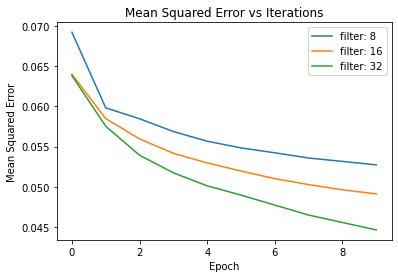

In [ ]:
import matplotlib.pyplot as plt 

# plotting the metrics

for his in li_history:
  plt.plot(his[0].history['loss'], label = f'filter: {his[1]}')
plt.title('Mean Squared Error vs Iterations')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/cnn_loss_a.png')

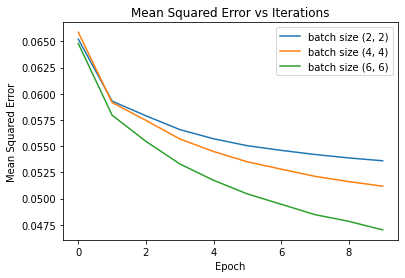

In [ ]:
import matplotlib.pyplot as plt 

# plotting the metrics

for his in li_history1:
  plt.plot(his[0].history['loss'], label = f'batch size {his[1]}')
plt.title('Mean Squared Error vs Iterations')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/cnn_loss_a.png')

In [ ]:
model_final = keras.Sequential(
      [
      layers.Conv2D(32, (6,6), activation='relu', input_shape=(7, 8, 8), padding='same'),
      layers.Dropout(0.1),
      layers.Conv2D(32, (6,6), activation='relu', padding='same'),
      layers.Dropout(0.1),
      layers.Conv2D(32, (6,6), activation='relu', padding='same'),
      layers.Dropout(0.1),
      layers.Flatten(), # need to be flatted from 2d to 1d
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation='relu'),
      ]
    )

model_final.compile(optimizer='adam',
                  loss='mean_squared_error')

history = model_final.fit(train_X, train_y, verbose=1, epochs=10, batch_size=32, validation_data=(test_X, test_y))

model_final.save("/content/drive/MyDrive/Colab Notebooks/CNN_chess_final1.h5")

Epoch 1/10
7899/7899 [==============================] - 320s 40ms/step - loss: 0.0509 - val_loss: 0.0447
Epoch 2/10
7899/7899 [==============================] - 324s 41ms/step - loss: 0.0433 - val_loss: 0.0407
Epoch 3/10
7899/7899 [==============================] - 325s 41ms/step - loss: 0.0400 - val_loss: 0.0378
Epoch 4/10
7899/7899 [==============================] - 318s 40ms/step - loss: 0.0373 - val_loss: 0.0361
Epoch 5/10
7899/7899 [==============================] - 322s 41ms/step - loss: 0.0353 - val_loss: 0.0339
Epoch 6/10
7899/7899 [==============================] - 321s 41ms/step - loss: 0.0336 - val_loss: 0.0326
Epoch 7/10
7899/7899 [==============================] - 323s 41ms/step - loss: 0.0322 - val_loss: 0.0318
Epoch 8/10
7899/7899 [==============================] - 323s 41ms/step - loss: 0.0311 - val_loss: 0.0317
Epoch 9/10
7899/7899 [==============================] - 327s 41ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 10/10
7899/7899 [==============================] 

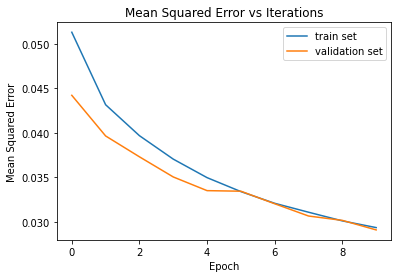

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], label = 'train set')
plt.plot(history.history['val_loss'], label = 'validation set')
plt.title('Mean Squared Error vs Iterations')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/cnn_loss_model.png')